d:\Anaconda\envs\torchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-15 23:53:51,568] A new study created in memory with name: no-name-ed9022a7-93f9-4c46-b2a0-d577be79b08e


Using device: cuda


[I 2025-08-15 23:53:55,870] Trial 0 finished with value: 0.1145890569730109 and parameters: {'lookback': 22, 'num_layers': 1, 'hidden_size': 120, 'lr': 0.0007706197999080553, 'batch_size': 32, 'kernel_size': 3}. Best is trial 0 with value: 0.1145890569730109.
[I 2025-08-15 23:53:57,752] Trial 1 finished with value: 0.14199190212058685 and parameters: {'lookback': 32, 'num_layers': 1, 'hidden_size': 18, 'lr': 0.0017610223335754935, 'batch_size': 32, 'kernel_size': 2}. Best is trial 0 with value: 0.1145890569730109.
[I 2025-08-15 23:53:58,119] Trial 2 finished with value: 0.1375075713320576 and parameters: {'lookback': 20, 'num_layers': 1, 'hidden_size': 118, 'lr': 0.009196675496332534, 'batch_size': 64, 'kernel_size': 2}. Best is trial 0 with value: 0.1145890569730109.
[I 2025-08-15 23:54:00,273] Trial 3 finished with value: 0.13636497989150284 and parameters: {'lookback': 31, 'num_layers': 1, 'hidden_size': 32, 'lr': 0.0027917182798991, 'batch_size': 16, 'kernel_size': 5}. Best is tria

Best hyperparameters: {'lookback': 33, 'num_layers': 3, 'hidden_size': 21, 'lr': 0.006489392404146263, 'batch_size': 16, 'kernel_size': 4}
Best validation RMSE: 0.08895499931295082
Multi-step Rolling Forecast (CNN+LSTM, 1-day blocks) Test Metrics: {
  "MSE": 5.154124017192636,
  "RMSE": 2.2702695913024593,
  "MAE": 1.7095250862523126,
  "MAPE%": 2.5730773697877076,
  "R2": 0.8528791547014197
}
Saved plot to cnn_lstm_pytorch_multistep_forecast_2024_1steps.png
Saved best params to best_cnn_lstm_params_multistep_1steps.json


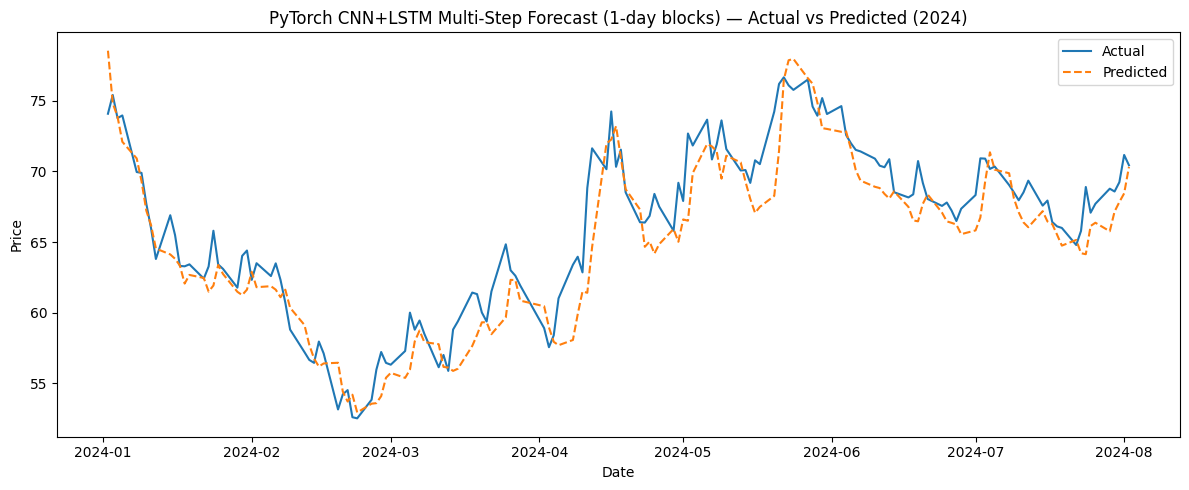

In [1]:
"""
Carbon Price Forecasting with PyTorch CNN+LSTM
- Multi-step Rolling Forecast with user-defined steps.
- The model predicts a block of days at a time, then uses ground truth to advance the window.
- The model uses a 1D CNN for feature extraction followed by an LSTM for sequential modeling.
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"
DATE_COL = "Date"
TARGET_COL = "Price"
FORECAST_STEPS = 1  # Number of steps to forecast ahead in a block

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test

def create_sequences(series_2d: np.ndarray, lookback: int):
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------- Model --------------------
class CNN_LSTMRegressor(nn.Module):
    def __init__(self, lookback: int, input_size: int, hidden_size: int, num_layers: int, kernel_size: int):
        super().__init__()
        # 1. CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate the size of the output from the CNN layer
        dummy_input = torch.randn(1, input_size, lookback)
        cnn_out_size = self.cnn(dummy_input).shape[2]

        # 2. LSTM for sequential modeling
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # 3. Fully connected layer for the final output
        self.head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x is (batch, seq_len, input_size)
        
        # Permute for CNN: (batch, input_size, seq_len)
        x = x.permute(0, 2, 1)
        
        # Pass through CNN layer
        cnn_out = self.cnn(x)
        
        # Permute back for LSTM: (batch, seq_len, features)
        rnn_in = cnn_out.permute(0, 2, 1)
        
        # Pass through LSTM layer
        out, _ = self.lstm(rnn_in)
        
        # Take the output of the last time step and pass to the head
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)
    df_train, df_val, df_test = train_val_test_split(df)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    def objective(trial: optuna.Trial):
        lookback    = trial.suggest_int("lookback", 15, 50)
        num_layers  = trial.suggest_int("num_layers", 1, 3)
        hidden_sz   = trial.suggest_int("hidden_size", 16, 128, log=True)
        lr          = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size  = trial.suggest_categorical("batch_size", [16, 32, 64])
        kernel_size = trial.suggest_int("kernel_size", 2, 5)
        epochs      = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        
        try:
            model = CNN_LSTMRegressor(lookback, input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
        except RuntimeError:
            return float('inf')

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0
        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return math.sqrt(best_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    best = study.best_params
    lookback    = best["lookback"]
    num_layers  = best["num_layers"]
    hidden_sz   = best["hidden_size"]
    lr          = best["lr"]
    batch_size  = best["batch_size"]
    kernel_size = best["kernel_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])
    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)

    model_final = CNN_LSTMRegressor(lookback, input_size=1, hidden_size=hidden_sz, num_layers=num_layers, kernel_size=kernel_size).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    # -------------------- Multi-step rolling forecast loop --------------------
    history = trainval_scaled.tolist()
    preds_scaled = []
    y_test_scaled = full_scaler.transform(df_test[[TARGET_COL]]).tolist()

    with torch.no_grad():
        for i in range(0, len(df_test), FORECAST_STEPS):
            temp_history = history.copy()
            block_preds = []
            for _ in range(FORECAST_STEPS):
                x_in = np.array(temp_history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
                x_tensor = torch.from_numpy(x_in).to(device)
                yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
                block_preds.append(yhat)
                temp_history.append([yhat])
            
            preds_scaled.extend(block_preds)

            for j in range(FORECAST_STEPS):
                if i + j < len(df_test):
                    history.append(y_test_scaled[i + j])
                else:
                    break
    
    preds_scaled = preds_scaled[:len(df_test)]

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    # -------------------- Metrics & Plot --------------------
    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print(f"Multi-step Rolling Forecast (CNN+LSTM, {FORECAST_STEPS}-day blocks) Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title(f'PyTorch CNN+LSTM Multi-Step Forecast ({FORECAST_STEPS}-day blocks) — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'cnn_lstm_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png', dpi=150)
    print(f"Saved plot to cnn_lstm_pytorch_multistep_forecast_2024_{FORECAST_STEPS}steps.png")

    with open(f'best_cnn_lstm_params_multistep_{FORECAST_STEPS}steps.json', 'w') as f:
        json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    print(f"Saved best params to best_cnn_lstm_params_multistep_{FORECAST_STEPS}steps.json")